In [1]:
from utils.libs import *

In [2]:
n_hf, n_hl = 64, 5
w, h = 256, 256
baseline_values_ws = "128,4096,4096,4096,4096,4096,64".split(",")
baseline_values_ws = list(map(float, baseline_values_ws))

tot_ws_baseline = sum(baseline_values_ws)
print('Tot number weigths', tot_ws_baseline)

baseline_values_bias = "2,64,64,64,64,64,1".split(",")
baseline_values_bias = list(map(float, baseline_values_bias))

tot_bias_baseline = sum(baseline_values_bias)
print('Tot number biases', tot_bias_baseline)

baseline_model_size_bit = (tot_bias_baseline + tot_ws_baseline) * 32
print("Baseline(Byte)", baseline_model_size_bit / 8, "Baseline(bit)", baseline_model_size_bit )

Tot number weigths 20672.0
Tot number biases 323.0
Baseline(Byte) 83980.0 Baseline(bit) 671840.0


Image size: (512, 512)


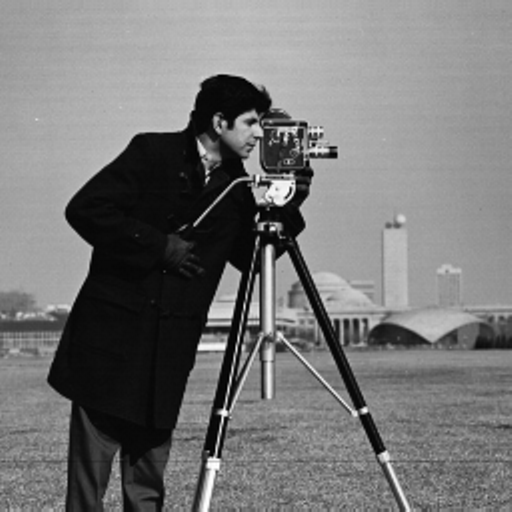

In [3]:
# --- Load target image.
im = load_target_image(image_file_path = None)
print('Image size:', im.size)
im

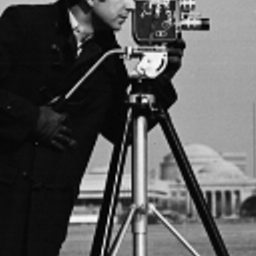

In [4]:
crop_size = (256,256)
im_cropped = get_cropped_by_center_image(im, target = crop_size)
im_cropped

In [5]:
cropped_file_size_bits = None
with BytesIO() as f:
    im_cropped.save(f, format='PNG')
    cropped_file_size_bits = f.getbuffer().nbytes * 8
    pass

In [6]:
result_jpeg_df = load_jpeg_baseline(im_cropped)

In [7]:
result_jpeg_df.head(5)

,mse,psnr,ssim,quality,file_size_bits,bpp,width,heigth,CR,compression
0,30.618301,33.270993,0.939424,20,33064,0.504517,256,256,7.682071,jpeg
1,28.949783,33.514350,0.940436,21,33968,0.518311,256,256,7.477626,jpeg
2,27.839966,33.684117,0.941620,22,34736,0.530029,256,256,7.312298,jpeg
3,26.316681,33.928492,0.944786,23,35408,0.540283,256,256,7.173520,jpeg
4,25.208344,34.115361,0.946817,24,36000,0.549316,256,256,7.055556,jpeg


In [8]:
jpeg_uniform_df = copy.deepcopy(result_jpeg_df)
jpeg_uniform_df.head(5)

,mse,psnr,ssim,quality,file_size_bits,bpp,width,heigth,CR,compression
0,30.618301,33.270993,0.939424,20,33064,0.504517,256,256,7.682071,jpeg
1,28.949783,33.514350,0.940436,21,33968,0.518311,256,256,7.477626,jpeg
2,27.839966,33.684117,0.941620,22,34736,0.530029,256,256,7.312298,jpeg
3,26.316681,33.928492,0.944786,23,35408,0.540283,256,256,7.173520,jpeg
4,25.208344,34.115361,0.946817,24,36000,0.549316,256,256,7.055556,jpeg


In [13]:
rename_columns = "file_size_bits".split(",")
renamed_columns = "size(byte)".split(",")
for old_col_name, new_col_name in zip(rename_columns, renamed_columns):
    if old_col_name not in jpeg_uniform_df.columns: continue
    jpeg_uniform_df[f"{new_col_name}"] = jpeg_uniform_df[f"{old_col_name}"].values
    jpeg_uniform_df = jpeg_uniform_df.drop([f"{old_col_name}"], axis = 1)
    pass

jpeg_uniform_df["size(byte)"] = jpeg_uniform_df["size(byte)"] / 8
jpeg_uniform_df["footprint(%)"] = jpeg_uniform_df["size(byte)"] * 8 / baseline_model_size_bit * 100

def create_compression_class_column(item):
    compression, quality = item
    return f"{compression.upper()}:{int(quality)}"

drop_columns = "quality,compression,width,heigth".split(",")
jpeg_uniform_df["cmprss-class"] = list(map(create_compression_class_column, jpeg_uniform_df[[f"compression", f"quality"]].values))
for old_col_name in drop_columns:
    if old_col_name not in jpeg_uniform_df.columns: continue
    jpeg_uniform_df = jpeg_uniform_df.drop([f"{old_col_name}"], axis = 1)
    pass

uniform_csv_dir = 'uniform_csv_files'
if not os.path.isdir(uniform_csv_dir):
    try: os.makedirs(uniform_csv_dir)
    except:pass
    pass

jpeg_uniform_df['date'] = ['-'] * jpeg_uniform_df.shape[0]
jpeg_uniform_df['init-from'] = ['-'] * jpeg_uniform_df.shape[0]
columns_order = "date,init-from,size(byte),footprint(%),psnr,bpp,CR,mse,ssim,cmprss-class".split(",")
jpeg_uniform_df = jpeg_uniform_df[columns_order]

jpeg_uniform_uniform_csv_path = os.path.join(f"{uniform_csv_dir}", "jpeg_uniform.csv")
jpeg_uniform_df.to_csv(jpeg_uniform_uniform_csv_path)
jpeg_uniform_df.head(5)

,date,init-from,size(byte),footprint(%),psnr,bpp,CR,mse,ssim,cmprss-class
0,-,-,8.072266,0.009612,33.270993,0.504517,7.682071,30.618301,0.939424,JPEG:20
1,-,-,8.292969,0.009875,33.514350,0.518311,7.477626,28.949783,0.940436,JPEG:21
2,-,-,8.480469,0.010098,33.684117,0.530029,7.312298,27.839966,0.941620,JPEG:22
3,-,-,8.644531,0.010294,33.928492,0.540283,7.173520,26.316681,0.944786,JPEG:23
4,-,-,8.789062,0.010466,34.115361,0.549316,7.055556,25.208344,0.946817,JPEG:24
